# Example: simple polynomial regression

This illustrates how I want to use the inversion package on the simplest linear example.

In [45]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from fatiando import utils
import cPickle as pickle
from inversion import LinearModel, Newton

In [2]:
class Regression(LinearModel):
    def __init__(self, degree):
        super().__init__(nparams=(degree + 1))
        self.degree = degree
        
    def predict(self, x):
        return sum(self.p_[i]*x**i for i in range(self.nparams))
        
    def jacobian(self, x):
        A = np.empty((x.size, self.nparams))
        for i in range(self.nparams):
            A[:, i] = x**i
        return A
    
    def fit(self, x, y, **kwargs):
        super().fit(data=y, args=[x], **kwargs)
        return self
    
    @property
    def polynomial_(self):
        eq = ' + '.join(['{:g}x**{}'.format(self.p_[i], i) 
                         for i in range(self.nparams)])
        return eq

# Test on data

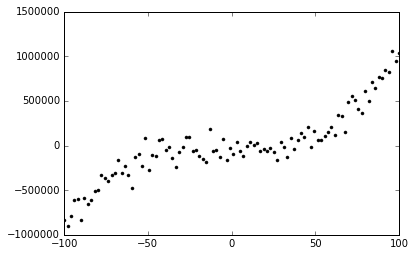

In [20]:
coefs = a, b, c, d = 1000, 10, 0, 1
n = 100
x = np.linspace(-100, 100, n)
y = a + b*x + c*x**2 + d*x**3
yo = utils.contaminate(y, 0.1, percent=True, seed=0)
plt.plot(x, yo, '.k')

In [21]:
reg = Regression(3)
reg.fit(x, yo).p_

array([ -4.31267826e+04,  -1.87119642e+02,   1.29758955e+01,
         1.00786859e+00])

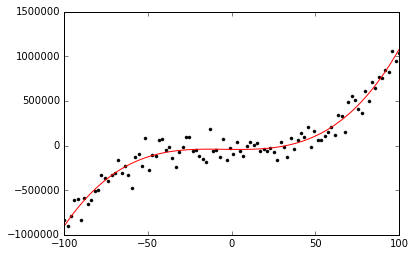

In [22]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

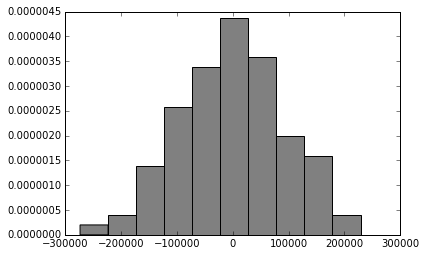

In [23]:
# No more residuals, since reg doesn't store the data
_ = plt.hist(yo - reg.predict(x), 10, normed=True, color='grey')

In [24]:
# Can be pickled for use in parallel
reg = pickle.loads(pickle.dumps(reg))

-43126.8x**0 + -187.12x**1 + 12.9759x**2 + 1.00787x**3


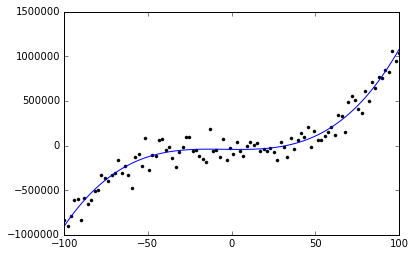

In [25]:
# Config still works
plt.plot(x, yo, '.k')
reg = Regression(3).config(optimizer=Newton(initial=np.ones(len(coefs))))
print(reg.fit(x, yo).polynomial_)
plt.plot(x, reg.predict(x), '-')

# Using cross-validation

In [26]:
rand = np.random.RandomState(42)
whole = rand.permutation(x.size)
divide = int(0.65*x.size)
train, test = whole[:divide], whole[divide:]

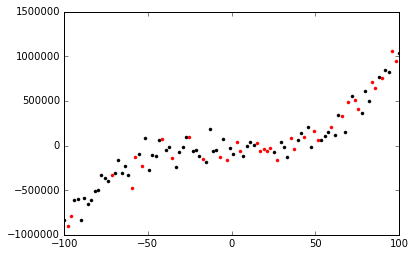

In [27]:
plt.plot(x[train], yo[train], '.k')
plt.plot(x[test], yo[test], '.r')

In [30]:
degrees = list(range(1, 20))
scores = [Regression(i).fit(x[train], yo[train]).score(x[test], yo[test], scorer='R2')
          for i in degrees]
best = degrees[np.argmax(scores)]
best

3

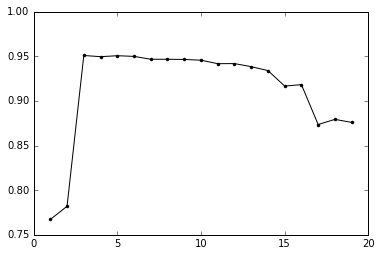

In [32]:
plt.plot(degrees, scores, '.-k')
#plt.yscale('log')

In [33]:
reg = Regression(best).fit(x, yo)
reg.polynomial_

'-43126.8x**0 + -187.12x**1 + 12.9759x**2 + 1.00787x**3'

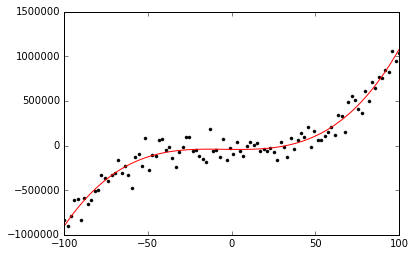

In [34]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Re-weighted

In [65]:
yo2 = np.copy(yo)
yo2[rand.choice(yo.size, size=5)] += 2e6

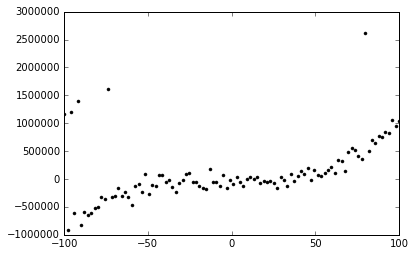

In [66]:
plt.plot(x, yo2, '.k')

In [67]:
reg = Regression(3).fit(x, yo2)
reg.polynomial_

'-108283x**0 + 2337.11x**1 + 61.5416x**2 + 0.324635x**3'

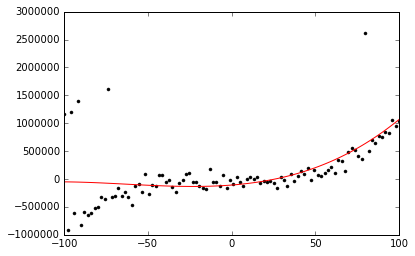

In [68]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg.predict(x), '-r')

In [80]:
reg2 = Regression(3).fit(x, yo2)
for i in range(10):
    r = np.abs(yo2 - reg2.predict(x))
    r[r < 1e-8] = 1e-8
    reg2.fit(x, yo2, weights=np.diag(1/r))
reg2.polynomial_

'-51853.7x**0 + 263.241x**1 + 17.2431x**2 + 0.89852x**3'

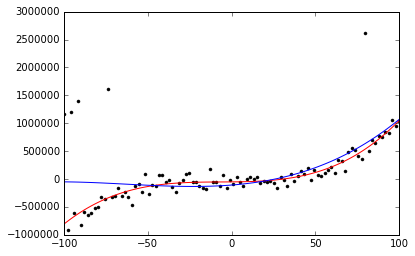

In [79]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg2.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

## Regularization

In [82]:
ridge = Regression(20)
rigde.config(regularization=[[10, Damping(ridge.nparams)]])
ridge.fit(x, yo).polynomial_

NameError: name 'Damping' is not defined

In [ ]:
mus = np.logspace(1, 15, 30)
A = Regression(3).jacobian(x[train])
scores = np.array(
     [Regression(3, damping=mu).fit(x[train], yo[train], jacobian=A[train]).mse(x[test], yo[test])
      for mu in mus])
mu = mus[np.argmin(scores)]

In [ ]:
plt.plot(mus, scores)
plt.plot(mu, scores.min(), '^k')
plt.xscale('log')
plt.yscale('log')

In [ ]:
ridge = Regression(3, damping=mu)
print(ridge.fit(x, yo).polynomial_)
plt.plot(x, yo, '.k')
plt.plot(x, ridge.predict(x), '-r')